In [ ]:
#importing libraries
from angle_detection import Rotation
import cv2
import matplotlib.pyplot as plt
import numpy as np
import angle_detection
import tools
import baseline_detection
from PIL import Image
import edge_superres
import criteria_definition
import visualization
import os
import shutil
import pandas as pd
import warnings


In [2]:
#adjusting image size (just for plotting)
plt.rcParams["figure.figsize"] = (15,10)

# Angle detection

In [ ]:
'''This function at first finds some pixels of the surface then fit a line
 and calculates the tilt angle based on the line angle. The accuracy of the
  measured angle is dependent on the contrast of the sample surface in the image.
   After rotating the image and making it horizontal, the surface line will be calculated.
    The surface line is the y coordinate of the topmost pixel line of the surface.'''

## Defining of the surface position and tilt angle value automatically

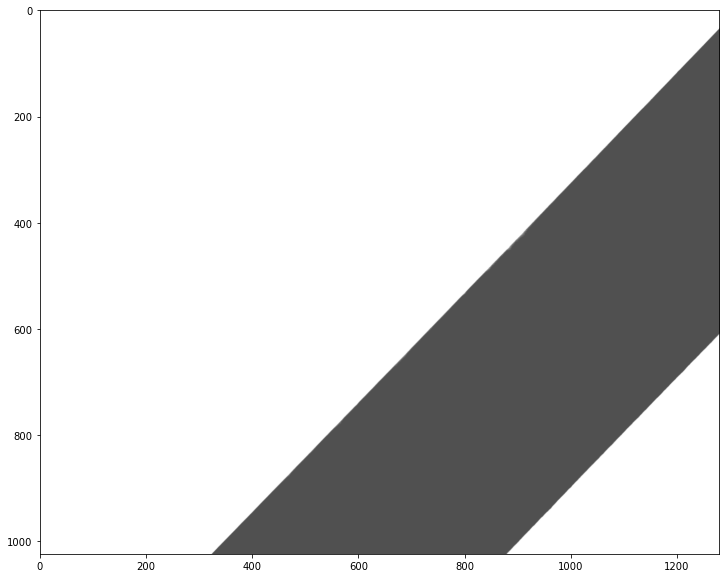

In [3]:
#loading the frame
img=cv2.imread("samples\\Frame.tif") 
img[img<80]=np.array([80]*len(list(img[img<80])))# to make the black tilted plate gray, just for presentation reasons.
plt.imshow(img) 

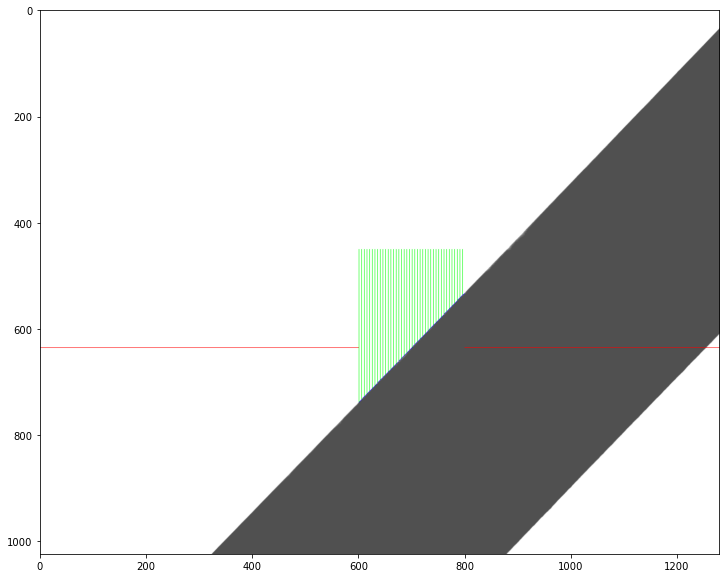

In [4]:
#setting parameters and detecting the surface 
Rotate=Rotation(starting_height=450,horizontal_search_area_start=600,horizontal_search_area_end=800,object_detection_threshold=200) 
img_detected,x_detected_before_rotation,y_detected_before_rotation,horizontal_line=Rotate.detect_surface(img) 
plt.imshow(img_detected)

The tilt angle before rotating was: 45.9 degree
The surface line height after rotation is: 641.0 px (red line)


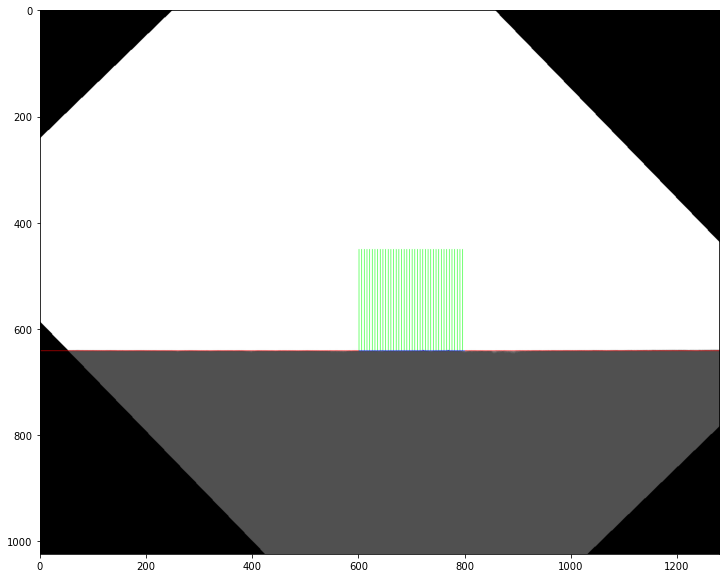

In [5]:
#calculating the tilt angle and rotate the frame (making it horizontal)
angle=Rotate.tilt_calculation(x_detected_before_rotation,y_detected_before_rotation) 
print("The tilt angle before rotating was: {:0.1f} degree".format(angle))
rotated_image=Rotate.rotate(img,angle,mode="constant") #mode options: {‘reflect’, ‘grid-mirror’, ‘constant’, ‘grid-constant’, ‘nearest’, ‘mirror’, ‘grid-wrap’, ‘wrap’}
img_detected,*rotated_details=Rotate.detect_surface(rotated_image)
print("The surface line height after rotation is: {:0.1f} px (red line)".format(rotated_details[-1]))
plt.imshow(img_detected)

## Defining of the surface position and tilt angle value manually (for transparent samples)

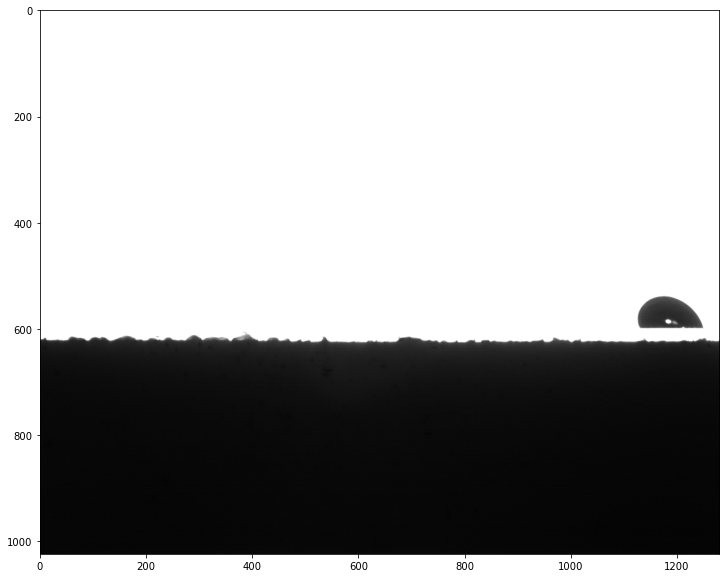

In [6]:
#loading the frame
img=cv2.imread("samples\\Transparent drop.tif")
plt.imshow(img)

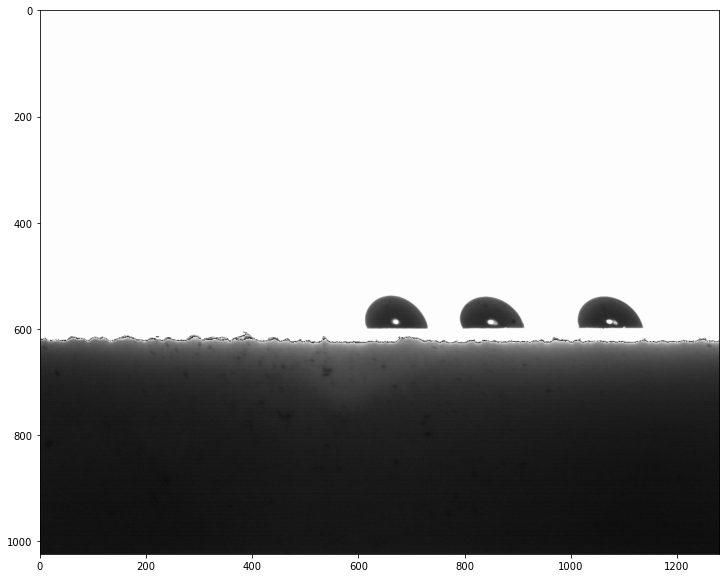

In [7]:
#loading the desired frames
#the surface is not visible so we will load three images and combine them to find the drop route. 
img1=cv2.imread("samples\\Transparent sample\\2_50DEG_Glass2_PFOTS_Drop_1_C001H001S0001000183.tif")
img2=cv2.imread("samples\\Transparent sample\\2_50DEG_Glass2_PFOTS_Drop_1_C001H001S0001000320.tif")
img3=cv2.imread("samples\\Transparent sample\\2_50DEG_Glass2_PFOTS_Drop_1_C001H001S0001000413.tif")
img=(img1+img2+img3).astype(int)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


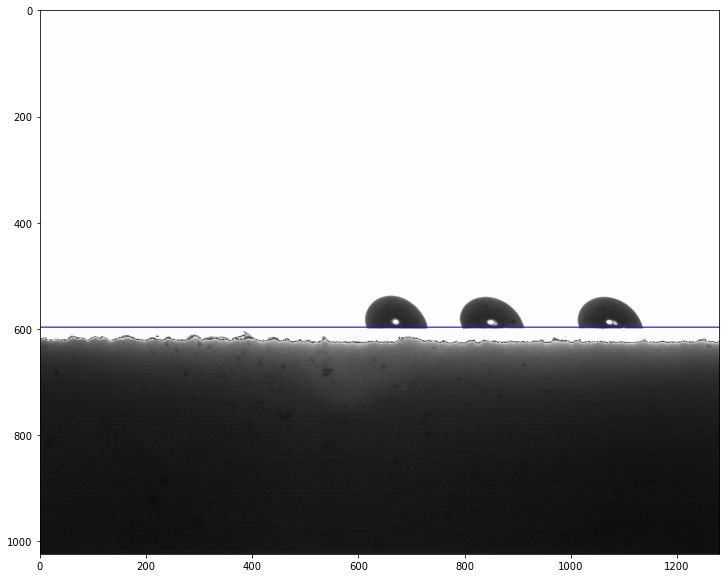

In [8]:
#defining surface-line and tilt angle manually
Rotate=Rotation()
manually_rotated=Rotate.manually_rotation( img, angle=0.1, surface_line=596) # adjust the angle and surface_line values
manually_rotated=manually_rotated.astype(int)
plt.imshow(manually_rotated)

# Baseline detection

In [ ]:
'''
There are some functions in baseline detection to find out the x and y coordinates
 of the drop and crop it by a margin. Then there are functions to detect the baseline position;
  edge-based and color-based. The edge-based method is a common method that can work for most cases.
   The color-based is a proposed method to detect a baseline based on changing the intensity
    of the droplet image color. After all mentioned processes, it is suggested to use the 
    test_baseline_detection function to make sure all measurements were true. 
    The output of this function is an image that can help the user to make sure 
    baseline position, tilt angle, and surface line were measured correctly.
'''

## Calculating the angle and rotating the image

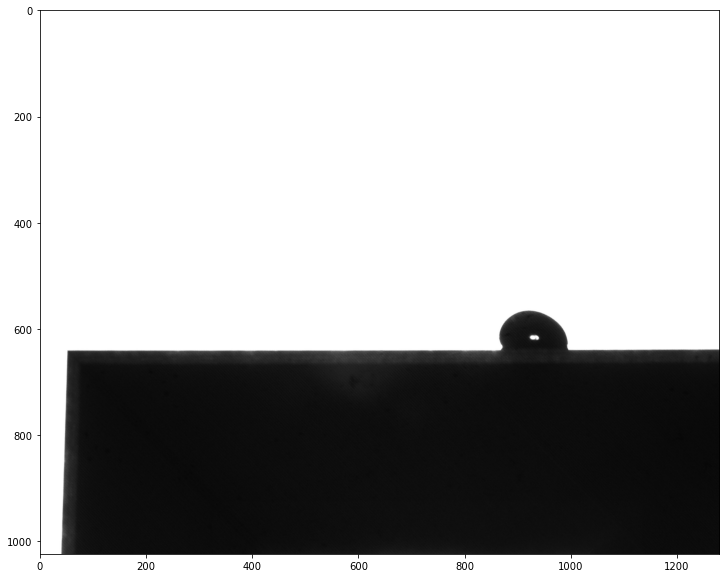

In [9]:
#1. loading the frame 
img=cv2.imread("samples\\Frame.tif") 

#2. rotation of the frame based on angle_detection function in reflect mode
Rotate=Rotation(starting_height=450,horizontal_search_area_start=400,horizontal_search_area_end=700,object_detection_threshold=200) 
img_detected,x_detected_before_rotation,y_detected_before_rotation,horizontal_line=Rotate.detect_surface(img) 
angle=Rotate.tilt_calculation(x_detected_before_rotation,y_detected_before_rotation) 
rotated_image_frame=Rotate.rotate(img,angle)

#3. loading the drop image and rotate it
img=cv2.imread("samples\\Drop.tif") 
rotated_image_drop=Rotate.rotate(img,angle)
plt.imshow(rotated_image_drop) 

## Measuring the baseline for a normal sample

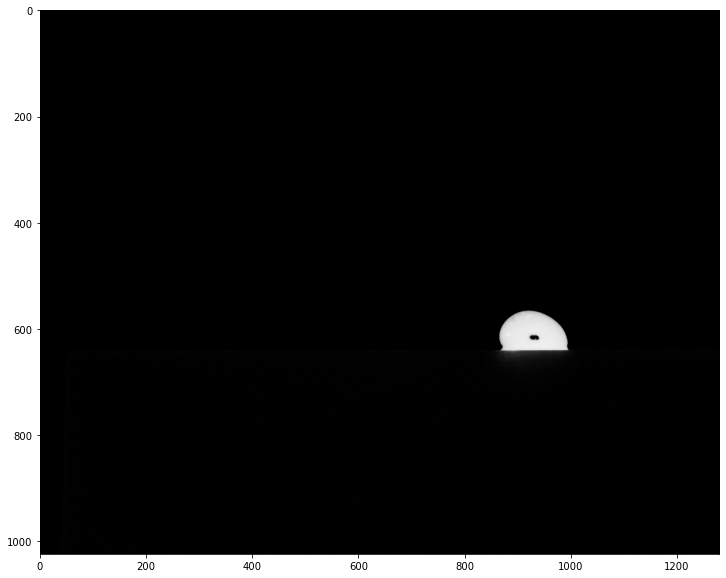

In [10]:
#removing the background
surface_line=Rotate.detect_surface(rotated_image_frame)[-1]
diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)
plt.imshow(diff_img)

In [11]:
#find out if the drop exists in the image or not. drop existence function helps to find out if there is any droplet in the frame or not, we will use it to skip empty frames
BaseL=baseline_detection.Baseline(surface_line, middle_drop_height=25, drop_start_height=0, object_detection_threshold=40)
drop_existence,x_left=BaseL.drop_existence(diff_img)
print("Is there any drop? {}, Left side x coordinate: {:0.0f}".format(drop_existence,x_left))

Is there any drop? True, Left side x coordinate: 864


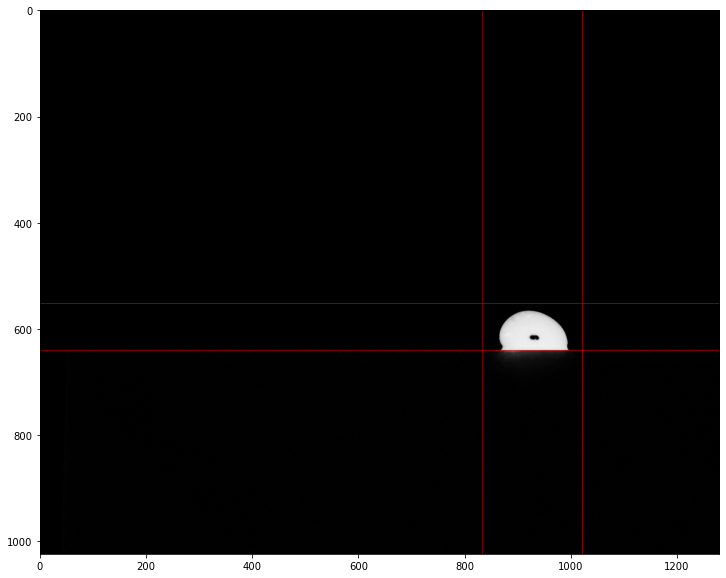

In [12]:
#finding the droplet position and crop it based on input margins
drop_reflection,*dim=BaseL.drop_cropping(diff_img, x_left_margin=30, x_right_margin=30,y_up_margin=10)
diff_img[:,dim[0]-1,:]=[255,0,0]
diff_img[:,dim[1],:]=[255,0,0]
diff_img[dim[2]-1,:,:]=[255,0,0]
diff_img[dim[3],:,:]=[255,0,0]
plt.imshow(diff_img)

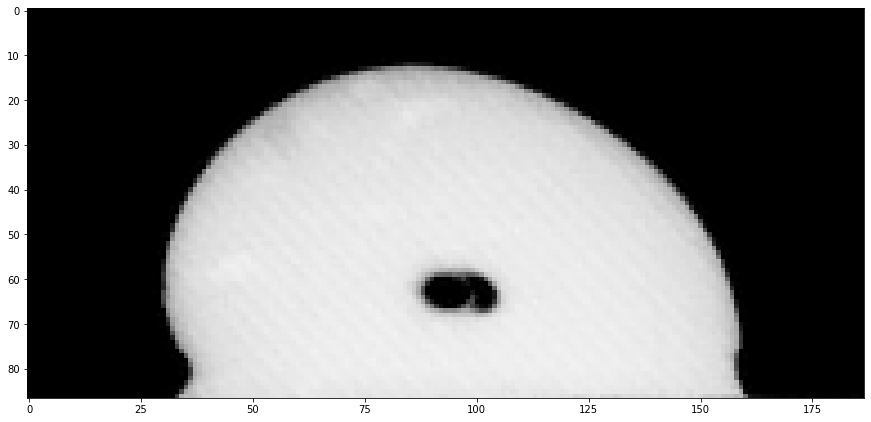

In [13]:
#cropped droplet
plt.imshow(drop_reflection)

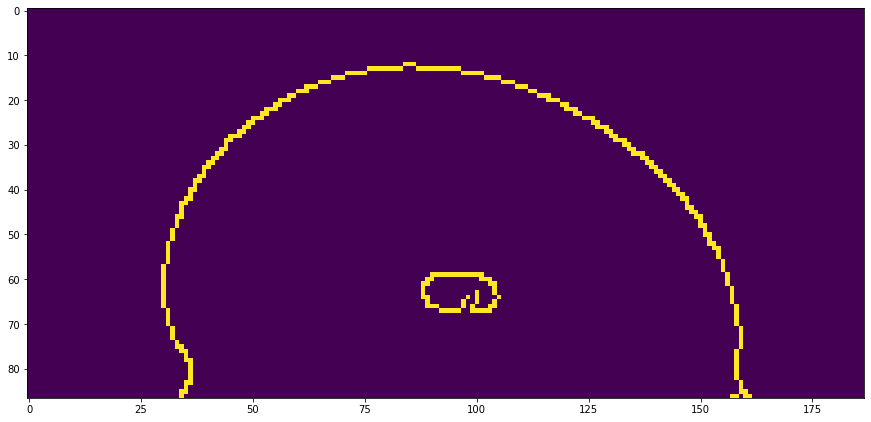

In [14]:
#calculating the drop edge based on canny edge detector
canny_just_drop=baseline_detection.edgebased_baseline_detection(drop_reflection)[1]
baseline=baseline_detection.edgebased_baseline_detection(drop_reflection)[2]
plt.imshow(canny_just_drop)

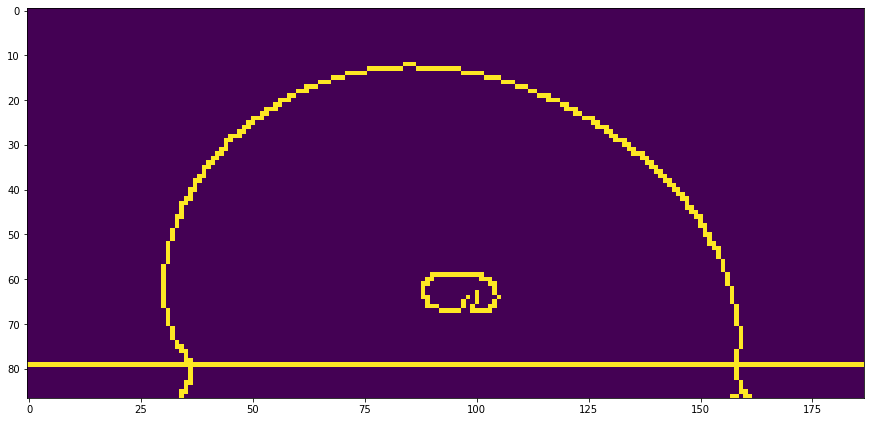

In [15]:
#finding the baseline based on edgebased_baseline_detection function
canny_just_drop=baseline_detection.edgebased_baseline_detection(drop_reflection)[1]
baseline=baseline_detection.edgebased_baseline_detection(drop_reflection)[2]
canny_just_drop[baseline,:]=255
plt.imshow(canny_just_drop)

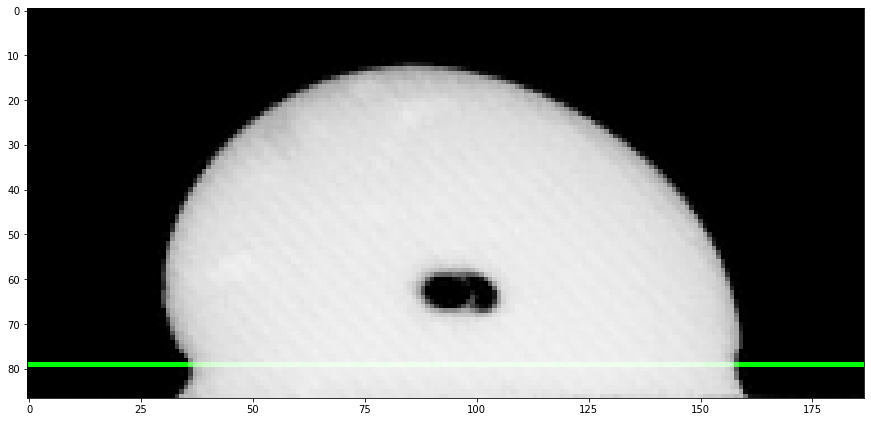

In [16]:
#baseline in the real image
drop_reflection_baseline=drop_reflection.copy()
drop_reflection_baseline[baseline,:,1]=255
plt.imshow(drop_reflection_baseline)

1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 
 The baseline is 98.0


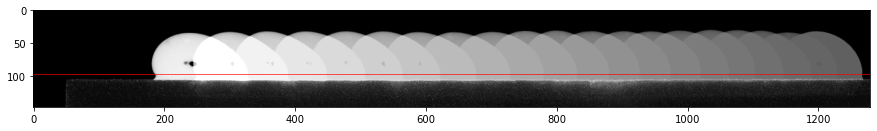

In [17]:
#it is possible to use the test_baseline_detection function to make sure detected angle, surface line, and baseline are correct 
#loading the frame
add=r"samples\Normal sample"
name_files=tools.load_files(add,formatt='tif') #a function to load all similar formats pictures in a folder 
img=cv2.imread(add+"\\"+name_files[0])

#calculating the angle and surface line and rotate images
Rotate=Rotation(starting_height=450,horizontal_search_area_start=600,horizontal_search_area_end=800,object_detection_threshold=200) 
img_detected,x_detected_before_rotation,y_detected_before_rotation,horizontal_line=Rotate.detect_surface(img) 
angle=Rotate.tilt_calculation(x_detected_before_rotation,y_detected_before_rotation) 
rotated_image_frame=Rotate.rotate(img,angle)
surface_line=Rotate.detect_surface(rotated_image_frame)[-1]

test_img,all_baselines=baseline_detection.test_baseline_detection(address=add, frame_index=0, startingframe_index=1, endingframe_index=len(name_files),
                                angle=angle, surface_line=surface_line, interval=5, alpha = 0.95, 
                                up_margin= 30, down_margin= 50)
plt.imshow(test_img)
print("\n The baseline is {:0.1f}".format(int(np.median(all_baselines))))

## Measuring the baseline for a transparent sample

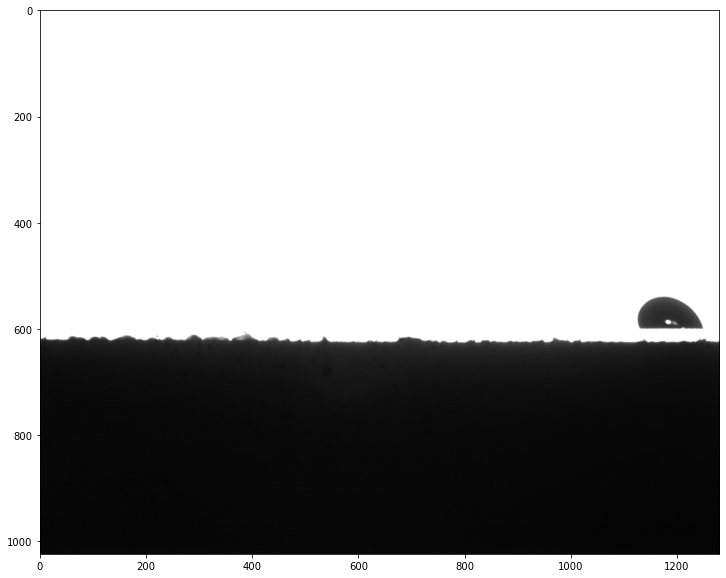

In [19]:
#1. loading the frame 
img0=cv2.imread("samples\\Transparent frame.tif") 

#2. rotation of the frame based on angle_detection function in reflect mode
angle=0.1
surface_line=620
rotated_image_frame=Rotate.rotate(img0,angle)

#3. loading the drop image and rotate it
img=cv2.imread("samples\\Transparent drop.tif") 
rotated_image_drop=Rotate.rotate(img,angle)
plt.imshow(rotated_image_drop)

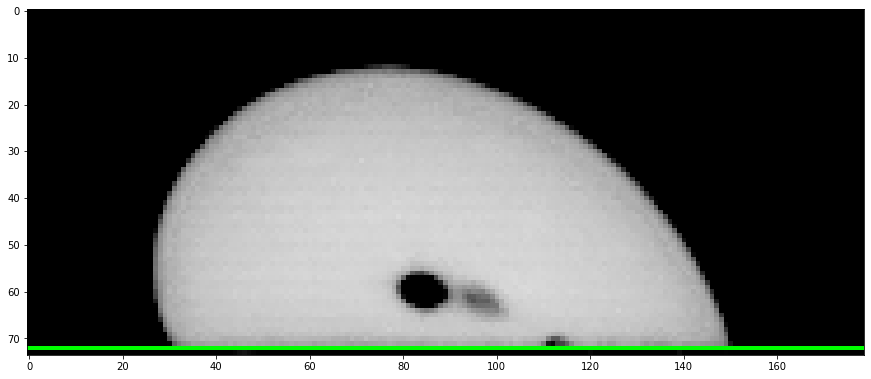

In [20]:
#finding the baseline based on colorbased_baseline_detectionfunction
BaseL=baseline_detection.Baseline(surface_line, middle_drop_height=25,drop_start_height=0, object_detection_threshold=40)
diff_img=cv2.absdiff(img0, img)
drop_reflection,*dim=BaseL.drop_cropping(diff_img, x_left_margin=30, x_right_margin=30,y_up_margin=10)
baseline=baseline_detection.colorbased_baseline_detection(drop_reflection)
drop_reflection[baseline,:,:]=[0,255,0]
plt.imshow(drop_reflection)

1, 51, 101, 151, 201, 251, 301, 
 The baseline is 111.0


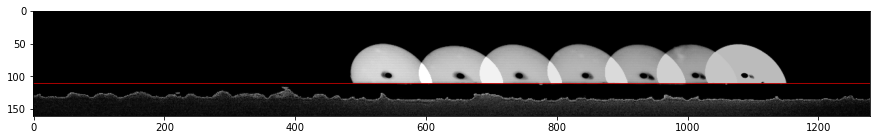

In [21]:
#validation
add=r"samples\Transparent sample"
name_files=tools.load_files(add,formatt='tif')
test_img,all_baselines=baseline_detection.test_baseline_detection(address=add, frame_index=0, startingframe_index=1, endingframe_index=len(name_files),
                                angle=angle, surface_line=surface_line, interval=50, alpha = 0.95, 
                                up_margin= 50, down_margin= 50)
plt.imshow(test_img)
print("\n The baseline is {:0.1f}".format(int(np.median(all_baselines))))

# Drop Check

In [ ]:
'''After recording a video using a high-speed camera, always there are some empty
 frames (without a droplet inside) that there is no need to analyze. To skip these
  kinds of frames, usually, users need to input the starting and ending frame numbers 
  manually which is time-consuming for bulk analysis. Also, in some frames, half of the
   droplet is inside the image and it is impossible to analyze both CAs. We need to skip
    them as well. The drop check function helps to find the correct video frames to do analysis.
     The drop existence means the frame is not empty and the droplet is inside. 
     The left side indicators are representing if the droplet is completely inside 
     or the left side of the droplet is out. The right side indicators are representing
      if the droplet is completely inside or if the right side of the droplet has not been entered yet. 
      The correct frame is when the drop existence is one and others zero.'''

## The correct droplet image

drop existence: 1 
left side indicators: 0 0 
right side indicators: 0 0


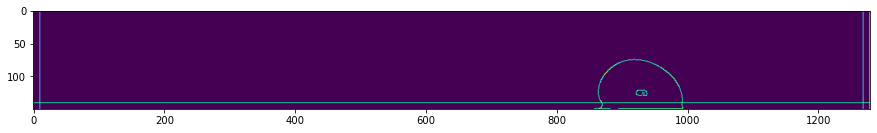

In [22]:
#1. loading the frame 
img=cv2.imread("samples\\Frame.tif") 

#2. rotation of the frame based on angle_detection function in reflect mode
Rotate=Rotation(starting_height=450,horizontal_search_area_start=400,horizontal_search_area_end=700,object_detection_threshold=200) 
img_detected,x_detected_before_rotation,y_detected_before_rotation,horizontal_line=Rotate.detect_surface(img) 
angle=Rotate.tilt_calculation(x_detected_before_rotation,y_detected_before_rotation) 
rotated_image_frame=Rotate.rotate(img,angle)

#3. loading the drop image and rotate it
img=cv2.imread("samples\\Drop.tif") 
rotated_image_drop=Rotate.rotate(img,angle)

#4. removing the background
surface_line=Rotate.detect_surface(rotated_image_frame)[-1]
diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)

#find out if the droplet is in a good position or not
drop_existence, left_drop_1, left_drop_2, right_drop_1, right_drop_2,check_img=tools.drop_check(diff_img,surface_y=surface_line, pic_y_length=150, vertical_margin=10 , horizontal_margin=10)
plt.imshow(check_img)
print("drop existence:",drop_existence,
      "\nleft side indicators:", left_drop_1, left_drop_2, 
      "\nright side indicators:", right_drop_1, right_drop_2)

## The wrong droplet images

drop existence: 0 
left side indicators: 0 0 
right side indicators: 0 0


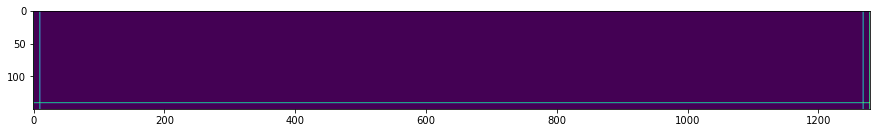

In [23]:
#3. loading the drop image and rotate it
img=cv2.imread("samples\\Frame.tif")
rotated_image_drop=Rotate.rotate(img,angle)

#4. removing the background
BaseL=baseline_detection.Baseline(surface_line, middle_drop_height=25, object_detection_threshold=40)
diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)

#find out if the droplet is in a good position or not
drop_existence, left_drop_1, left_drop_2, right_drop_1, right_drop_2,check_img=tools.drop_check(diff_img,surface_y=surface_line, pic_y_length=150, vertical_margin=10 , horizontal_margin=10)
plt.imshow(check_img)
print("drop existence:",drop_existence,
      "\nleft side indicators:", left_drop_1, left_drop_2, 
      "\nright side indicators:", right_drop_1, right_drop_2)

drop existence: 1 
left side indicators: 1 1 
right side indicators: 0 0


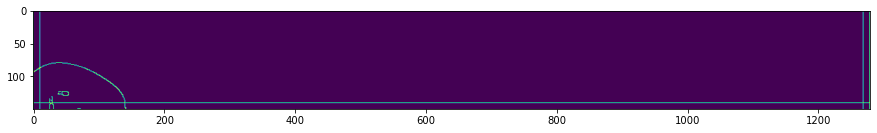

In [24]:
#3. loading the drop image and rotate it
img=cv2.imread("samples\\Drop_wrongposition.tif") 
rotated_image_drop=Rotate.rotate(img,angle)

#4. removing the background
surface_line=Rotate.detect_surface(rotated_image_frame)[-1]
diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)

#find out if the droplet is in a good position or not
drop_existence, left_drop_1, left_drop_2, right_drop_1, right_drop_2,check_img=tools.drop_check(diff_img,surface_y=surface_line, pic_y_length=150, vertical_margin=10 , horizontal_margin=10)
plt.imshow(check_img)
print("drop existence:",drop_existence,
      "\nleft side indicators:", left_drop_1, left_drop_2, 
      "\nright side indicators:", right_drop_1, right_drop_2)

# Edge superres

In [ ]:
'''Based on the developed super-resolution model we want to increase the droplet 
image dimension 9 times bigger (scale_factor=3). Then, using a canny edge detection 
algorithm the edge will be extracted. But there are some detected pixels inside of the
 droplet curvature that is not beneficial and should be removed. So, other functions help
  to select just external edge pixels and remove the rest of the pixels.'''

## Extracting external edge pixels for low-resolution image

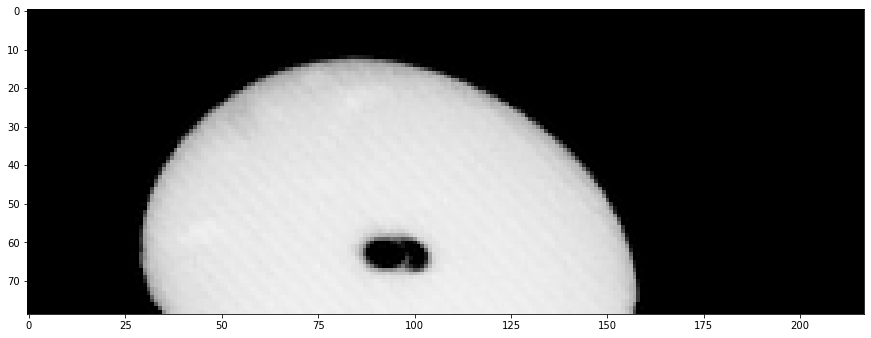

In [25]:
#1. loading the frame 
img=cv2.imread("samples\\Frame.tif") 

#2. rotation of the frame based on angle_detection function in reflect mode
Rotate=Rotation(starting_height=450,horizontal_search_area_start=400,horizontal_search_area_end=700,object_detection_threshold=200) 
img_detected,x_detected_before_rotation,y_detected_before_rotation,horizontal_line=Rotate.detect_surface(img) 
angle=Rotate.tilt_calculation(x_detected_before_rotation,y_detected_before_rotation) 
rotated_image_frame=Rotate.rotate(img,angle)

#3. loading the drop image and rotate it
img=cv2.imread("samples\\Drop.tif") 
rotated_image_drop=Rotate.rotate(img,angle)

#4. removing the background
surface_line=Rotate.detect_surface(rotated_image_frame)[-1]
diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)

#5. detecting the baseline and cropping the droplet part
BaseL=baseline_detection.Baseline(surface_line, middle_drop_height=20, object_detection_threshold=40)
diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)
drop_reflection,*dim=BaseL.drop_cropping(diff_img, x_left_margin=30, x_right_margin=60,y_up_margin=10)
just_drop=baseline_detection.edgebased_baseline_detection(drop_reflection)[0]

plt.imshow(just_drop)

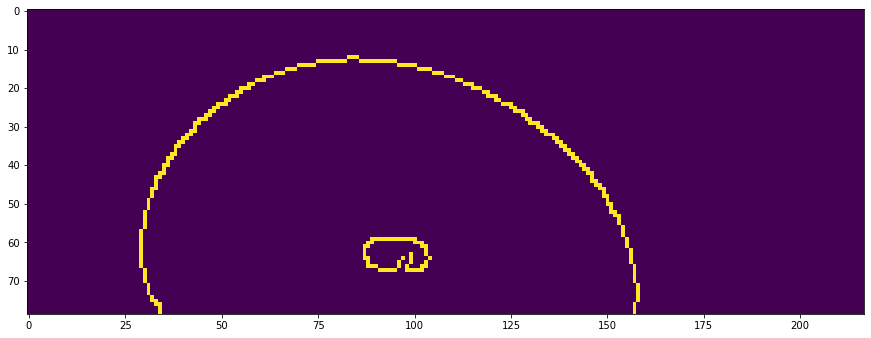

In [26]:
#a usual canny output for low-resolution droplet image
plt.imshow(cv2.Canny(just_drop,100,200))

(22.55, 164.45, -3.3000000000000003, 69.3)

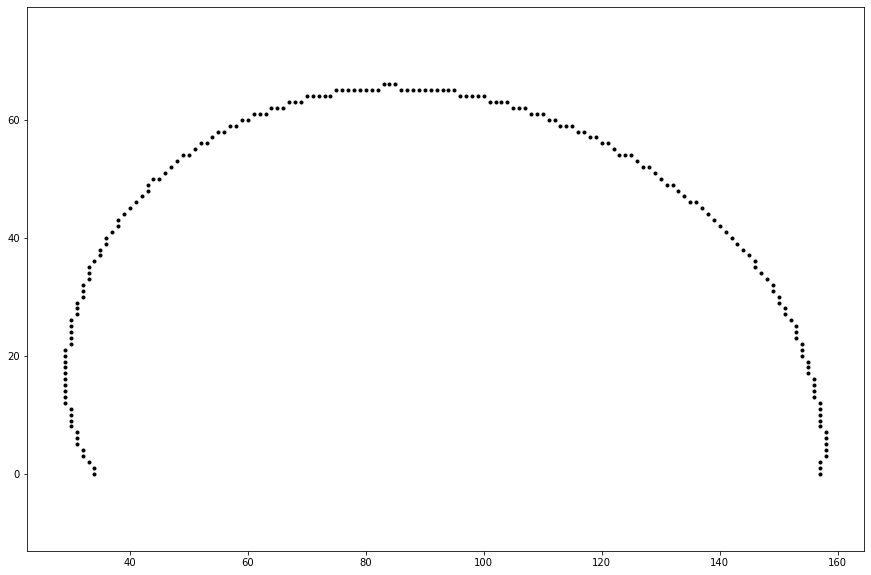

In [27]:
#keeping just external pixels as droplet curvature
i_list, j_list =edge_superres.edge_extraction_canny(just_drop, canny_v1=100, canny_v2=200)
plt.plot(i_list,j_list,'.',color='black')
plt.axis('equal')

## Extracting external edge pixels for super-resolution image

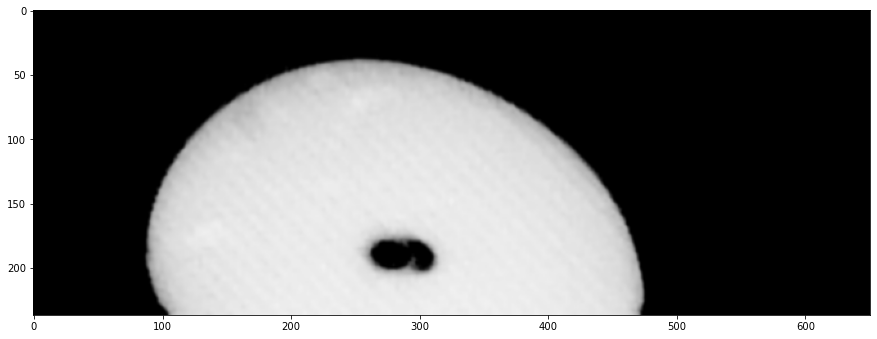

In [28]:
#loading the developed super-resolution model and using it to increase the image resolution
weight_address='SuperRes_weights.h5'
model=edge_superres.model_architecture(weight_address)
upscaled_image=edge_superres.upscale_image(model, Image.fromarray(just_drop.astype('uint8'), 'RGB'))
plt.imshow(upscaled_image)

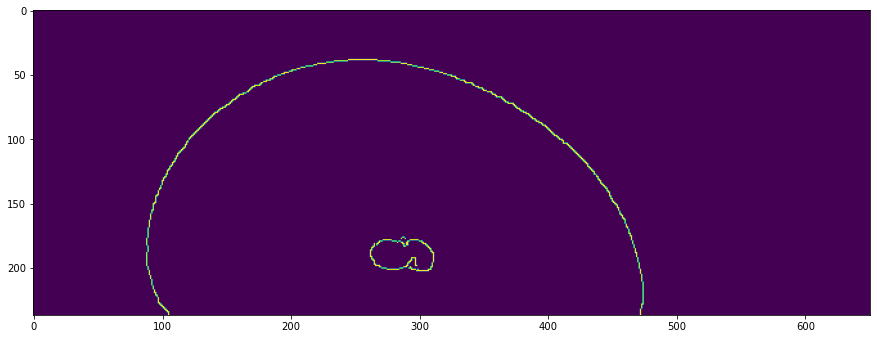

In [29]:
#a usual canny output for super-resolution droplet image
plt.imshow(cv2.Canny(upscaled_image,100,200))

(68.7, 493.3, -9.9, 207.9)

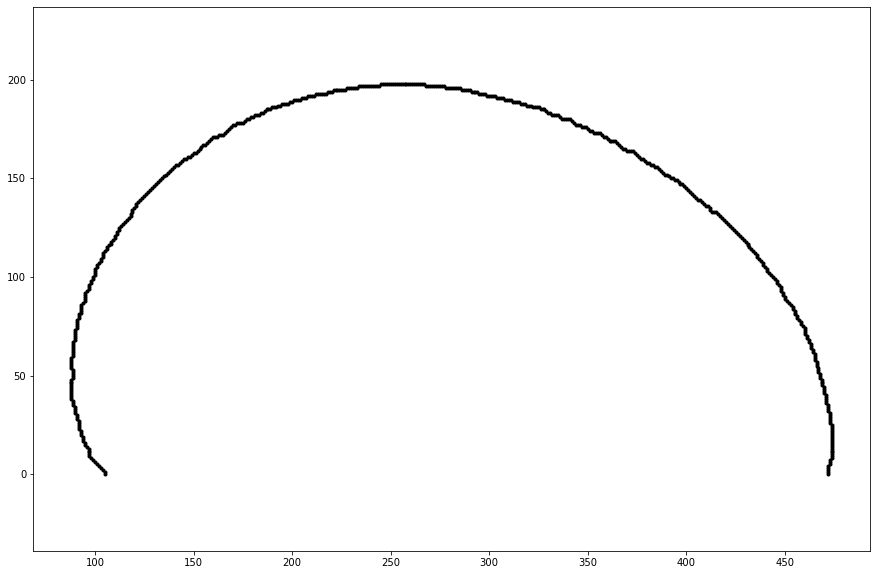

In [30]:
#keeping just external pixels as droplet curvature
i_list, j_list =edge_superres.edge_extraction_canny(upscaled_image, canny_v1=100, canny_v2=200)
plt.plot(i_list,j_list,'.',color='black')
plt.axis('equal')

# Criteria definition

In [ ]:
'''So far the droplet contour in super-resolution space is extracted and is ready
 to define some parameters to measure. In this step, we want to measure advancing
  and receding angles, x and y coordinates of the center of the droplet, and contact line length.'''

## Advancing and receding angles

(68.65, 494.35, -10.15, 213.15)

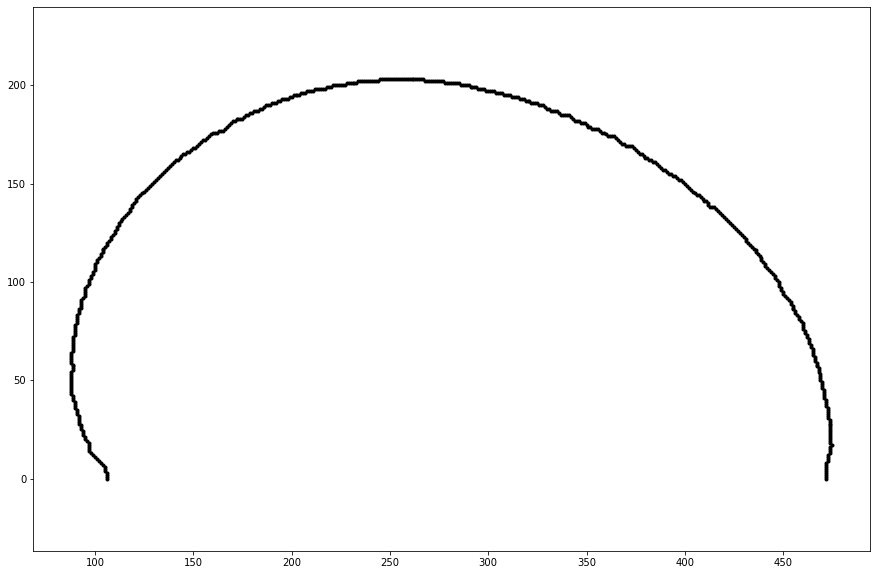

In [31]:
#1. loading the frame 
img=cv2.imread("samples\\Frame.tif") 

#2. rotation of the frame based on angle_detection function in reflect mode
Rotate=Rotation(starting_height=450,horizontal_search_area_start=400,horizontal_search_area_end=700,object_detection_threshold=200) 
img_detected,x_detected_before_rotation,y_detected_before_rotation,horizontal_line=Rotate.detect_surface(img) 
angle=Rotate.tilt_calculation(x_detected_before_rotation,y_detected_before_rotation) 
rotated_image_frame=Rotate.rotate(img,angle)

#3. loading the drop image and rotate it
img=cv2.imread("samples\\Drop.tif") 
rotated_image_drop=Rotate.rotate(img,angle)

#4. removing the background
surface_line=Rotate.detect_surface(rotated_image_frame)[-1]
diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)

#5. detecting the baseline and cropping the droplet part
BaseL=baseline_detection.Baseline(surface_line, middle_drop_height=20, object_detection_threshold=40)
diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)
drop_reflection,*dim=BaseL.drop_cropping(diff_img, x_left_margin=30, x_right_margin=60,y_up_margin=10)
just_drop=baseline_detection.edgebased_baseline_detection(drop_reflection)[0]
baseline=baseline_detection.edgebased_baseline_detection(drop_reflection)[2]

#6. loading the developed super-resolution model and using it to increase the image resolution
just_drop=just_drop[:baseline,:,:]
model=edge_superres.model_architecture("SuperRes_weights.h5")
upscaled_image=edge_superres.upscale_image(model, Image.fromarray(drop_reflection.astype('uint8'), 'RGB'))
upscaled_image=baseline_detection.edgebased_baseline_detection(np.array(upscaled_image),drop_check_height=3*11)[0]
required_height=upscaled_image.shape[0] 
upscaled_image=upscaled_image[:required_height,:,:] 

#7. utilizing morphological transformation to remove noises
kernel = np.ones((3,3),np.uint8) #3 is maximum allowed number
upscaled_image=cv2.morphologyEx(np.array(upscaled_image), cv2.MORPH_CLOSE, kernel)

#8. keeping just external pixels as droplet curvature
i_list, j_list =edge_superres.edge_extraction_canny(upscaled_image, canny_v1=100, canny_v2=200)

#plotting
plt.plot(i_list,j_list,'.',color='black')
plt.axis('equal')

(68.65, 494.35, -10.15, 213.15)

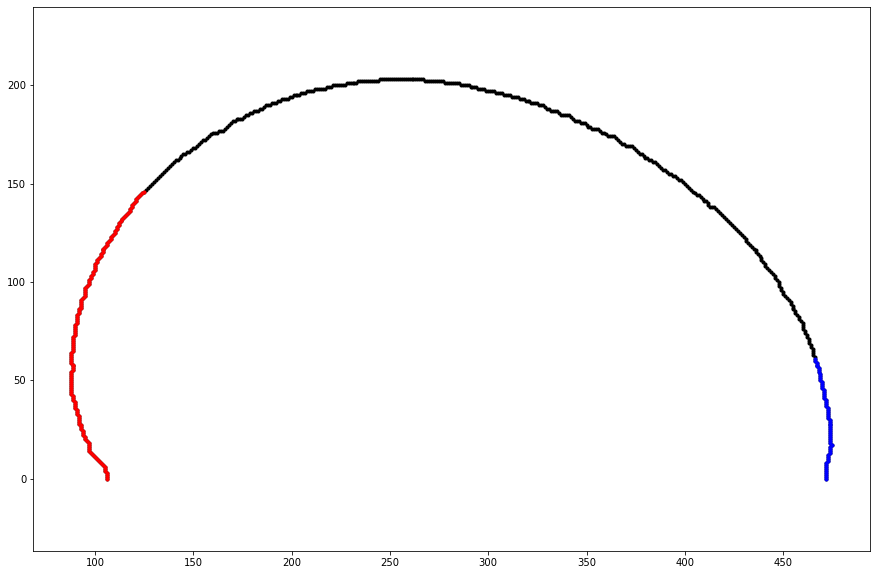

In [32]:
#extracting the desired number of pixels as input of the polynomial fitting 
#blue dotted are receding pixels
#red dotted are advancing pixels
i_left, j_left=criteria_definition.advancing_pixel_selection(i_list,j_list, left_number_of_pixels=150)
i_right, j_right=criteria_definition.receding_pixel_selection(i_list,j_list, right_number_of_pixels=65)

#plotting
plt.plot(i_list,j_list,'.',color='black')
plt.plot(i_left,j_left,'.',color='red')
plt.plot(i_right,j_right,'.',color='blue')
plt.axis('equal')

Advancing: 124.00378783176828 , Receding: 102.43778092561266


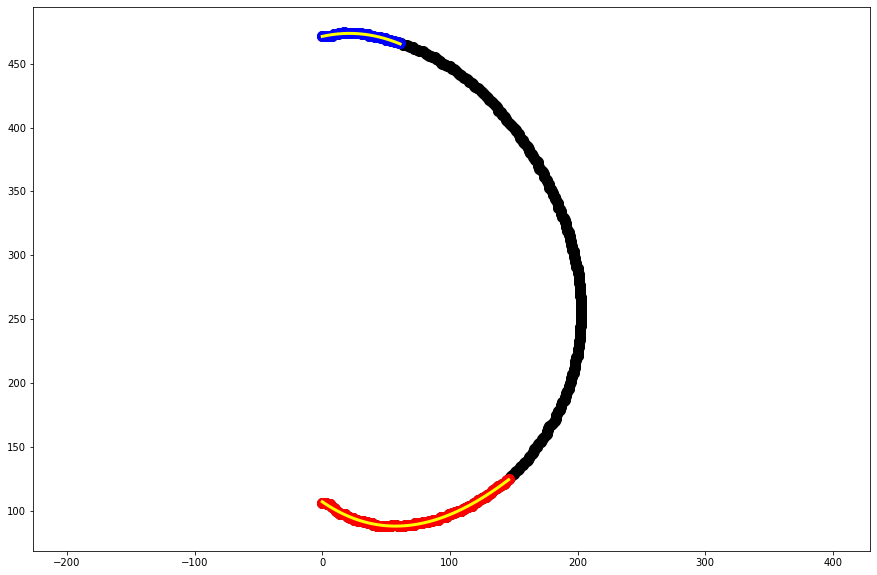

In [33]:
#fitting the polynomial on desired pixels
#yellow lines are fitted polynomials
#rotation before fitting. it increases the accuracy to rotate 90 degrees and then fitting the polynomial
i_left,j_left=j_left,i_left       
i_right,j_right=j_right,i_right   
i_list,j_list=j_list,i_list       

#fitting the polynomial
i_poly_left, j_poly_left=criteria_definition.poly_fitting(i_left,j_left,polynomial_degree=3,line_space=65)
i_poly_right, j_poly_right=criteria_definition.poly_fitting(i_right,j_right,polynomial_degree=2,line_space=150)

#plotting
plt.plot(i_list,j_list,'.',color='black',markersize=20)
plt.plot(i_left,j_left,'.',color='red',markersize=20)
plt.plot(i_right,j_right,'.',color='blue',markersize=20)
plt.plot(i_poly_right, j_poly_right,color='yellow',linewidth=3)
plt.plot(i_poly_left, j_poly_left,color='yellow',linewidth=3)
plt.axis('equal')
print("Advancing:",criteria_definition.left_angle(i_poly_left, j_poly_left)[0],", Receding:",criteria_definition.right_angle(i_poly_right, j_poly_right)[0])

(68.53413413832989, 494.3555174219843, -10.15, 213.15)

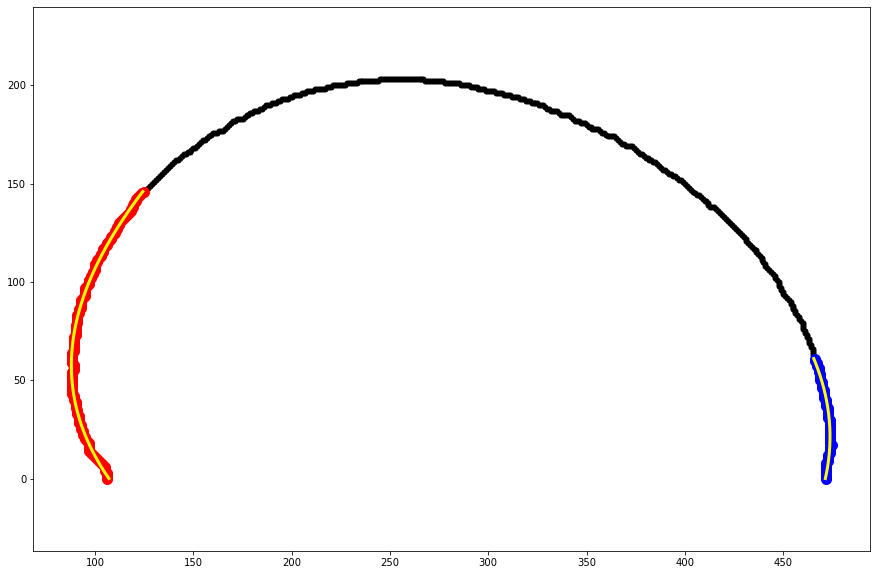

In [34]:
#rotating it back to do other analyses based on real coordinates
i_list,j_list=j_list,i_list
i_poly_right, j_poly_right, i_poly_left, j_poly_left = j_poly_right, i_poly_right, j_poly_left, i_poly_left
i_left,j_left,i_right,j_right=j_left,i_left,j_right,i_right

#plotting
plt.plot(i_list,j_list,'.',color='black',markersize=10)
plt.plot(i_left,j_left,'.',color='red',markersize=20)
plt.plot(i_right,j_right,'.',color='blue',markersize=20)
plt.plot(i_poly_right, j_poly_right,color='yellow',linewidth=3)
plt.plot(i_poly_left, j_poly_left,color='yellow',linewidth=3)
plt.axis('equal')

## The center coordinates

In [ ]:
'''In the next cell, we are trying to find the line that will divide
 the droplet horizontally into two equal areas. For example, when y=0, x will be
  equal to 106 and 472. So we calculated the red dot for y=0 like (106+472)/2=289.
   Then we repeated the same procedure for all other values of the y and plotted all the red dots.
    Then we calculated the blue line position based on a weighted average of the red dots. 
    The weights were considered the difference between the two x values of a 
    specific y as the area (472-106=366). In addition, we observed that the red dots 
    are always similar to a tilted line. The idea was that fitting a line to red dots and measuring 
    the tilt of the line could be meaningful. So the green dashed line is the fitted line on the red dots.'''

(68.65, 494.35, -10.330880330808691, 216.9484869469825)

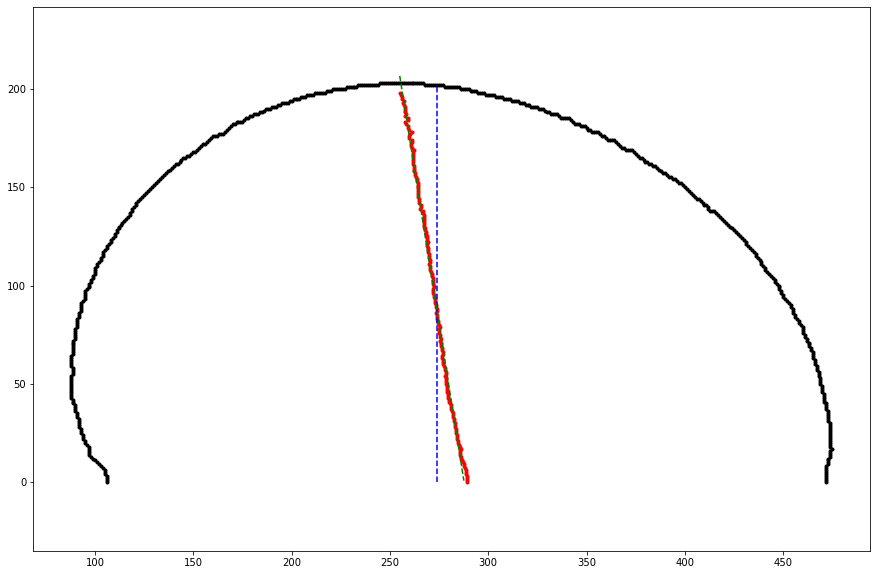

In [35]:
#finding the line that will divide the droplet horizontally into two equal area
i_list, j_list = np.array(i_list), np.array(j_list)
h_center,i_mean,j_mean=criteria_definition.horizontal_center(i_list,j_list,intersection_margin=4)
i_middle_line=criteria_definition.poly_fitting(i_mean,j_mean,polynomial_degree=1,line_space=100)[0]
j_middle_line=criteria_definition.poly_fitting(i_mean,j_mean,polynomial_degree=1,line_space=100)[1]

#plotting
plt.plot(i_list,j_list,'.',color='black')
plt.plot(i_mean,j_mean,'.',color='red')
plt.plot([h_center,h_center],[min(j_list),j_list[i_list==int(h_center)][0]],'--',color='blue')
plt.plot(i_middle_line[j_middle_line>0], j_middle_line[j_middle_line>0],'--',color='green')
criteria_definition.middle_angle(i_middle_line, j_middle_line)
plt.axis('equal')

In [ ]:
'''In the next cell, we are trying to find the line that will divide the droplet 
vertically into two equal areas. The logic is the same as the last one.
 The intersection of the vertical and horizontal dividers will be considered 
 as the center of the drop, and the velocity of this point will be used to report the velocity of the drop.'''

(68.65, 494.35, -10.15, 213.15)

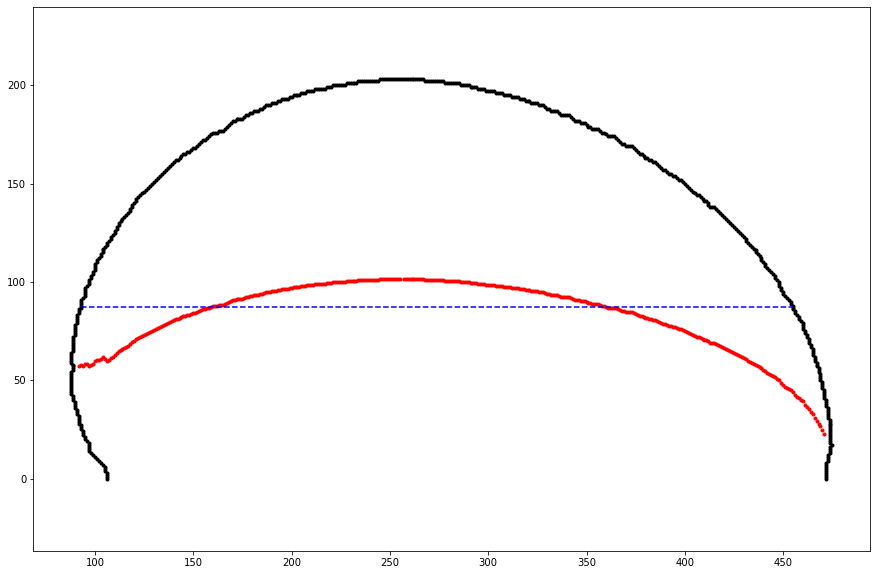

In [36]:
#finding the line that will divide the droplet vertically into two equal area
v_center,i_mean,j_mean=criteria_definition.vertical_center(i_list,j_list,intersection_margin=4)

#plotting
plt.plot(i_list,j_list,'.',color='black')
plt.plot(i_mean,j_mean,'.',color='red')
plt.plot([i_list[j_list==int(v_center)][0],i_list[j_list==int(v_center)][-1]],[v_center,v_center],'--',color='blue')
plt.axis('equal')

# Visualization

In [ ]:
'''This function is for visualizing defined criteria.
 In this way, the user can check video processing is working well.'''

In [37]:
#1. loading the frame 
img=cv2.imread("samples\\Frame.tif") 

#2. rotation of the frame based on angle_detection function in reflect mode
Rotate=Rotation(starting_height=450,horizontal_search_area_start=400,horizontal_search_area_end=700,object_detection_threshold=200) 
img_detected,x_detected_before_rotation,y_detected_before_rotation,horizontal_line=Rotate.detect_surface(img) 
angle=Rotate.tilt_calculation(x_detected_before_rotation,y_detected_before_rotation) 
rotated_image_frame=Rotate.rotate(img,angle)

#3. loading the drop image and rotate it
img=cv2.imread("samples\\Drop.tif") 
rotated_image_drop=Rotate.rotate(img,angle)

#4. removing the background
surface_line=Rotate.detect_surface(rotated_image_frame)[-1]
diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)

#5. detecting the baseline and cropping the droplet part
BaseL=baseline_detection.Baseline(surface_line, middle_drop_height=20, object_detection_threshold=40)
diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)
drop_reflection,*dim=BaseL.drop_cropping(diff_img, x_left_margin=30, x_right_margin=60,y_up_margin=10)
just_drop=baseline_detection.edgebased_baseline_detection(drop_reflection)[0]
baseline=baseline_detection.edgebased_baseline_detection(drop_reflection)[2]

#6. loading the developed super-resolution model and using it to increase the image resolution
just_drop=just_drop[:baseline,:,:]
model=edge_superres.model_architecture("SuperRes_weights.h5")
upscaled_image=edge_superres.upscale_image(model, Image.fromarray(drop_reflection.astype('uint8'), 'RGB'))
upscaled_image=baseline_detection.edgebased_baseline_detection(np.array(upscaled_image),drop_check_height=3*11)[0]
required_height=upscaled_image.shape[0] 
upscaled_image=upscaled_image[:required_height,:,:] 

#7. utilizing morphological transformation to remove noises
kernel = np.ones((3,3),np.uint8) #3 is maximum allowed number
upscaled_image=cv2.morphologyEx(np.array(upscaled_image), cv2.MORPH_CLOSE, kernel)

#8. keeping just external pixels as droplet curvature
i_list, j_list =edge_superres.edge_extraction_canny(upscaled_image, canny_v1=100, canny_v2=200)

#9. extracting the desired number of pixels as input of the polynomial fitting 
left_number_of_pixels=150
right_number_of_pixels=65
i_left, j_left=criteria_definition.advancing_pixel_selection(i_list,j_list, left_number_of_pixels=left_number_of_pixels)
i_right, j_right=criteria_definition.receding_pixel_selection(i_list,j_list, right_number_of_pixels=right_number_of_pixels)

#10. rotation for fitting, it can increase the accuracy to rotate 90 degrees then fit the polynomial
i_left_rotated,j_left_rotated=j_left,i_left       
i_right_rotated,j_right_rotated=j_right,i_right   
i_poly_left_rotated, j_poly_left_rotated=criteria_definition.poly_fitting(i_left_rotated,j_left_rotated,polynomial_degree=3,line_space=left_number_of_pixels)
i_poly_right_rotated, j_poly_right_rotated=criteria_definition.poly_fitting(i_right_rotated,j_right_rotated,polynomial_degree=2,line_space=right_number_of_pixels)
j_poly_left=i_poly_left_rotated
i_poly_left=j_poly_left_rotated
j_poly_right=i_poly_right_rotated
i_poly_right=j_poly_right_rotated

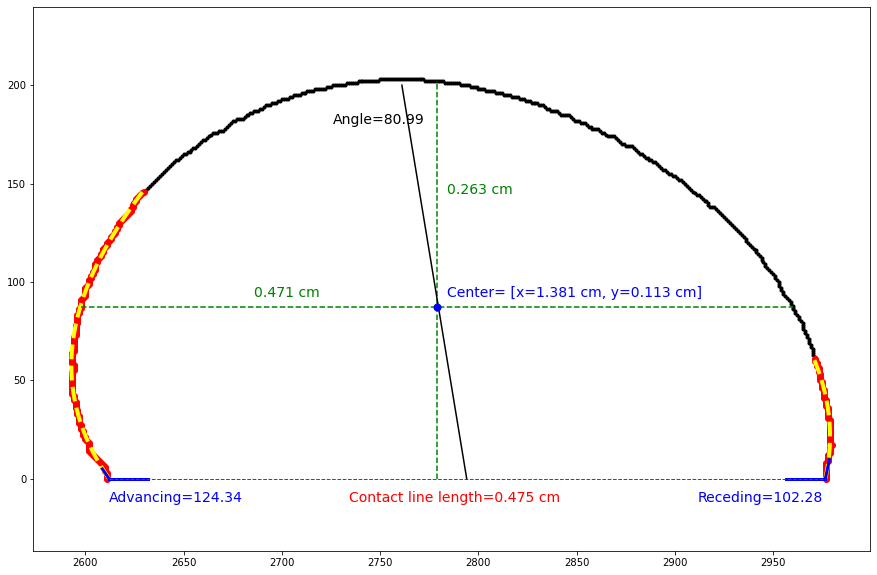

In [38]:
x_cropped=dim[0]
distance=(x_cropped)*3
address='analyzed droplet.png'
adv, rec,right_angle_point, left_angle_point, contact_line_length, x_center, y_center, middle_angle_degree=visualization.visualize(address, 
                                                                                                                                   distance+np.array(i_list),j_list,distance+np.array(i_left),j_left,distance+np.array(i_right),j_right,
                                                                                                                                   j_poly_left,distance+np.array(i_poly_left),j_poly_right,distance+np.array(i_poly_right),x_cropped,
                                                                                                                                   distance+np.array(i_poly_left_rotated), j_poly_left_rotated, distance+np.array(i_poly_right_rotated),
                                                                                                                                   j_poly_right_rotated, middle_line_switch=1)

# A real example

In [ ]:
'''In continue, there is an example of all mentioned functions to analyze
 a video and convert it to different diagrams.'''

## Baseline test

1, 26, 51, 76, 101, 126, 151, 176, 201, 226, 251, 276, 301, 326, 

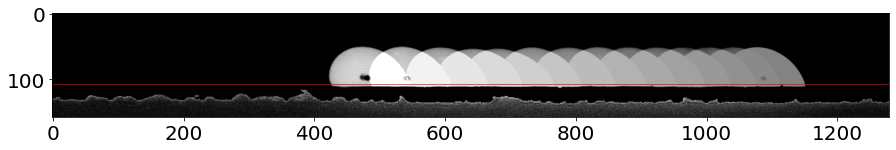

In [39]:
#validation
add=r"samples\Transparent sample"
angle=0.1
surface_line=600
name_files=tools.load_files(add,formatt='tif')
up_margin=50
test_img,baseline_all=baseline_detection.test_baseline_detection(address=add, frame_index=0, startingframe_index=1, endingframe_index=len(name_files),
                                angle=angle, surface_line=surface_line, interval=25, alpha = 0.95, 
                                up_margin= up_margin, down_margin= 50)
baseline=int(np.median(baseline_all))
plt.imshow(test_img)

## Video analysis

There are 347 files
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

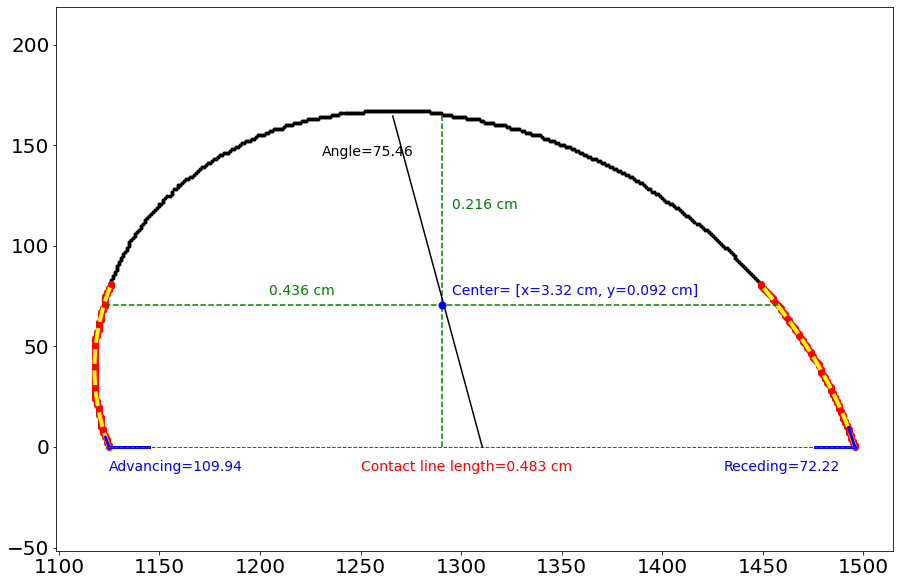

In [41]:
add=r"samples\Transparent sample"
name_files=tools.load_files(add,formatt='tif')
warnings.filterwarnings("ignore")
#Make Folders+++++++++++++++++++++++++++++++++++++++++++++++++++++++
NewFolder2=add+"\\"+"SR_edge"
try:
    os.makedirs(NewFolder2)
except:
    shutil.rmtree(NewFolder2)
    os.makedirs(NewFolder2)
NewFolder3=add+"\\"+"SR_result"
try:
    os.makedirs(NewFolder3)
except:
    shutil.rmtree(NewFolder3)
    os.makedirs(NewFolder3)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#1. loading the frame 
img=cv2.imread(add+"\\"+name_files[0]) 

#2. rotation of the frame based on angle_detection function in reflect mode
Rotate=Rotation(starting_height=450,horizontal_search_area_start=400,horizontal_search_area_end=700,object_detection_threshold=200) 
img_detected,x_detected_before_rotation,y_detected_before_rotation,horizontal_line=Rotate.detect_surface(img) 
angle=Rotate.tilt_calculation(x_detected_before_rotation,y_detected_before_rotation) 
rotated_image_frame=Rotate.rotate(img,angle)

adv_list, rec_list, contact_line_length_list, x_center_list, y_center_list, middle_angle_degree_list,processed_number_list=[],[],[],[],[],[],[]
rec_angle_point_list, adv_angle_point_list=[],[]
counter=0
print("There are {} files".format(len(name_files)))
for file_number in range(1,len(name_files)-1):
    print(file_number,end=", ")
    counter+=1
    
    #3. loading the drop image and rotate it
    img=cv2.imread(add+"\\"+name_files[file_number]) 
    rotated_image_drop=Rotate.rotate(img,angle)

    #4. removing the background
    diff_img=cv2.absdiff(rotated_image_drop, rotated_image_frame)
    

    #5. detecting the baseline and cropping the droplet part
    BaseL=baseline_detection.Baseline(surface_line, middle_drop_height=20, object_detection_threshold=40)
    if counter==1:
        drop_reflection,*dim=BaseL.drop_cropping(diff_img, x_left_margin=30, x_right_margin=60,y_up_margin=up_margin)
    else:
        drop_reflection, dim[0], dim[1], _, dim[3]=BaseL.drop_cropping(diff_img, x_left_margin=30, x_right_margin=60,y_up_margin=up_margin)
    

    #6. loading the developed super-resolution model and using it to increase the image resolution
    just_drop=drop_reflection[:baseline,:,:]
    model=edge_superres.model_architecture("SuperRes_weights.h5")
    upscaled_image=edge_superres.upscale_image(model, Image.fromarray(just_drop.astype('uint8'), 'RGB'))

    #7. utilizing morphological transformation to remove noises
    kernel = np.ones((3,3),np.uint8) #3 is maximum allowed number
    upscaled_image=cv2.morphologyEx(np.array(upscaled_image), cv2.MORPH_CLOSE, kernel)

    #8. keeping just external pixels as droplet curvature
    i_list, j_list =edge_superres.edge_extraction(upscaled_image, thr=80)

    #9. extracting the desired number of pixels as input of the polynomial fitting 
    left_number_of_pixels=150
    right_number_of_pixels=65
    i_left, j_left=criteria_definition.advancing_pixel_selection(i_list,j_list, left_number_of_pixels=left_number_of_pixels)
    i_right, j_right=criteria_definition.receding_pixel_selection(i_list,j_list, right_number_of_pixels=right_number_of_pixels)

    #10. rotation for fitting, it can increase the accuracy to rotate 90 degrees then fit the polynomial
    i_left_rotated,j_left_rotated=j_left,i_left       
    i_right_rotated,j_right_rotated=j_right,i_right   

    left_polynomial_degree=3
    right_polynomial_degree=2
    i_poly_left_rotated, j_poly_left_rotated=criteria_definition.poly_fitting(i_left_rotated,j_left_rotated,polynomial_degree=left_polynomial_degree,line_space=left_number_of_pixels)
    i_poly_right_rotated, j_poly_right_rotated=criteria_definition.poly_fitting(i_right_rotated,j_right_rotated,polynomial_degree=right_polynomial_degree,line_space=right_number_of_pixels)

    right_angle_degree,right_angle_point=criteria_definition.right_angle(i_poly_right_rotated, j_poly_right_rotated,1)
    left_angle_degree,left_angle_point=criteria_definition.left_angle(i_poly_left_rotated, j_poly_left_rotated,1)
    
    if left_angle_degree<=60:
        left_number_of_pixels=60
        left_polynomial_degree=2
    elif 60<left_angle_degree<=105:
        left_number_of_pixels=85
        left_polynomial_degree=2
    elif 105<left_angle_degree<=135:
        left_number_of_pixels=140
        left_polynomial_degree=3
    elif 135<left_angle_degree:
        left_number_of_pixels=215
        left_polynomial_degree=4
        
    if right_angle_degree<=60:
        right_number_of_pixels=60
        right_polynomial_degree=2
    elif 60<right_angle_degree<=105:
        right_number_of_pixels=85
        right_polynomial_degree=2
    elif 105<right_angle_degree<=135:
        right_number_of_pixels=175
        right_polynomial_degree=3
    elif 135<right_angle_degree:
        right_number_of_pixels=215
        right_polynomial_degree=4
        
    #9. extracting the desired number of pixels as input of the polynomial fitting 
    i_left, j_left=criteria_definition.advancing_pixel_selection(i_list,j_list, left_number_of_pixels=left_number_of_pixels)
    i_right, j_right=criteria_definition.receding_pixel_selection(i_list,j_list, right_number_of_pixels=right_number_of_pixels)

    #10. rotation for fitting, it can increase the accuracy to rotate 90 degrees then fit the polynomial
    i_left_rotated,j_left_rotated=j_left,i_left       
    i_right_rotated,j_right_rotated=j_right,i_right   
    i_poly_left_rotated, j_poly_left_rotated=criteria_definition.poly_fitting(i_left_rotated,j_left_rotated,polynomial_degree=left_polynomial_degree,line_space=left_number_of_pixels)
    i_poly_right_rotated, j_poly_right_rotated=criteria_definition.poly_fitting(i_right_rotated,j_right_rotated,polynomial_degree=right_polynomial_degree,line_space=right_number_of_pixels)
    j_poly_left=i_poly_left_rotated
    i_poly_left=j_poly_left_rotated
    j_poly_right=i_poly_right_rotated
    i_poly_right=j_poly_right_rotated
    x_cropped=dim[0]

    #11. Visualization
    distance=(x_cropped)*3
    address=add+'\\'+'SR_edge'+'\\'+str(name_files[file_number])
    adv, rec,rec_angle_point, adv_angle_point, contact_line_length, x_center, y_center, middle_angle_degree=visualization.visualize(address, 
                                                                                                                                    distance+np.array(i_list),j_list,distance+np.array(i_left),j_left,distance+np.array(i_right),j_right,
                                                                                                                                   j_poly_left,distance+np.array(i_poly_left),j_poly_right,distance+np.array(i_poly_right),x_cropped,
                                                                                                                                   distance+np.array(i_poly_left_rotated), j_poly_left_rotated, distance+np.array(i_poly_right_rotated),
                                                                                                                                   j_poly_right_rotated, middle_line_switch=1)
    processed_number_list.append(int(file_number))
    adv_list.append(adv)
    rec_list.append(rec)
    adv_angle_point_list.append(adv_angle_point)
    rec_angle_point_list.append(rec_angle_point)
    contact_line_length_list.append(contact_line_length)
    x_center_list.append(x_center)
    y_center_list.append(y_center)
    middle_angle_degree_list.append(middle_angle_degree)
    
vel=[]
for i in range(len(x_center_list)-1):
    vel=vel+[x_center_list[i+1]-x_center_list[i]]
    
df=pd.DataFrame([processed_number_list,adv_list,rec_list,contact_line_length_list, x_center_list, y_center_list, middle_angle_degree_list, vel]).T
df.columns=['number', 'adv', 'rec', 'contact_line_length', 'x_center', 'y_center', 'middle_angle_degree', 'velocity']
df.to_excel(add+'\\'+'SR_result'+'\\'+'result.xlsx')

## CAs diagram

(0.0, 160.0)

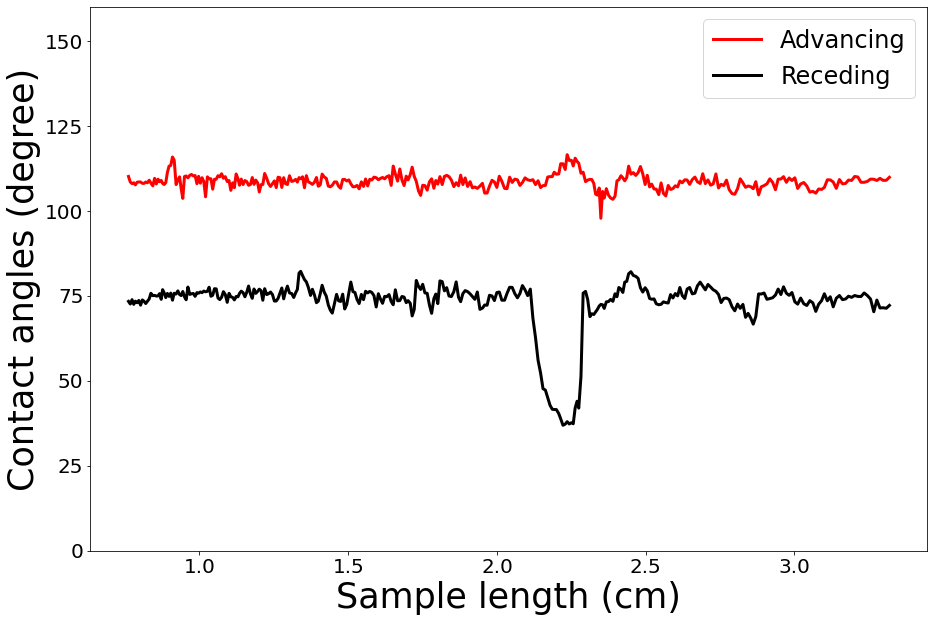

In [42]:
plt.plot(df["x_center"],df["adv"],'-',linewidth=3,color="red", label="Advancing")
plt.rcParams["figure.figsize"] = (15,10)

font_size=35
plt.xlabel('Sample length',fontdict={'size':font_size})
plt.ylabel('Advancing',fontdict={'size':font_size})

plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=35) 

plt.plot(df["x_center"],df["rec"],'-',linewidth=3,color="black", label="Receding")
plt.rcParams["figure.figsize"] = (15,10)

font_size=35
plt.xlabel('Sample length (cm)',fontdict={'size':font_size})
plt.ylabel('Contact angles (degree)',fontdict={'size':font_size})

plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=35) 
plt.legend(fontsize=24)
plt.ylim([0, 160])


## Contact line length diagram

(0.4, 0.6)

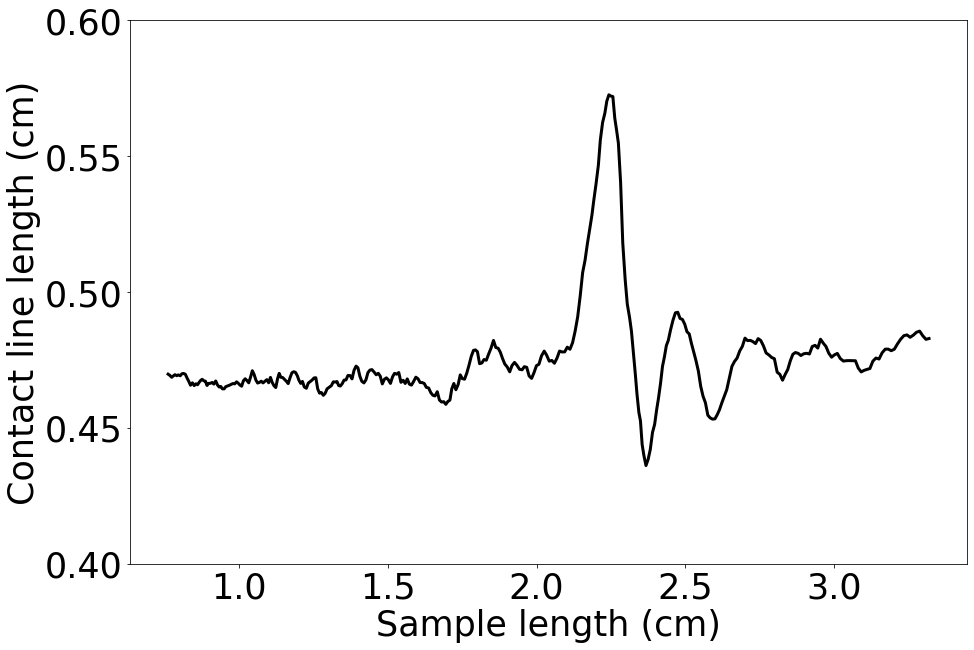

In [43]:
plt.plot(df["x_center"],df["contact_line_length"],'-',linewidth=3,color="black", label="Original plot")

font_size=35
plt.xlabel('Sample length (cm)',fontdict={'size':font_size})
plt.ylabel('Contact line length (cm)',fontdict={'size':font_size})

plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=35) 

plt.ylim([.4, 0.60])

## Median line angle diagram

(0.0, 100.0)

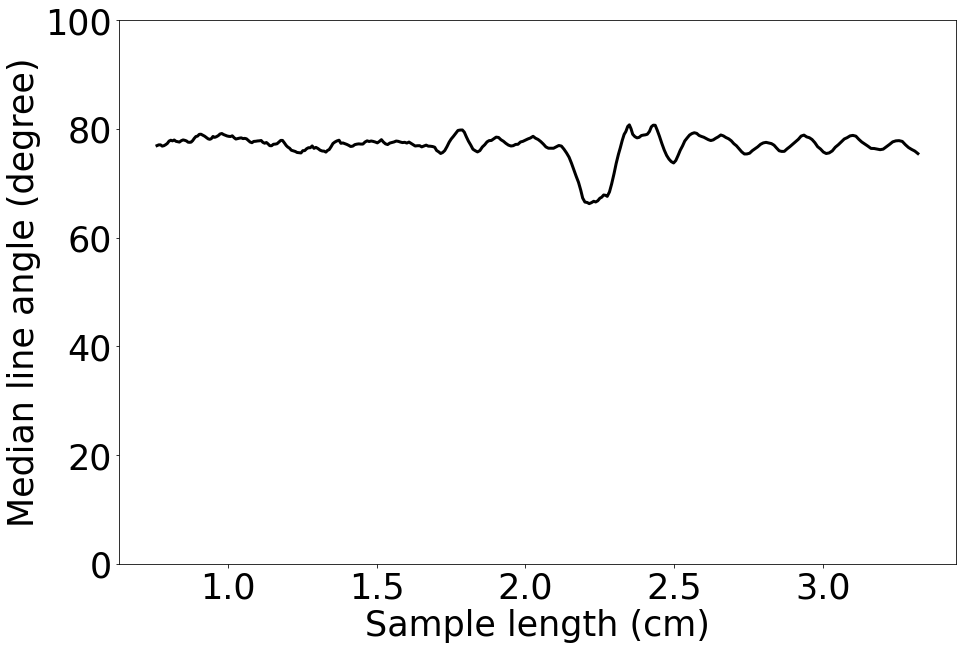

In [44]:
plt.plot(df["x_center"],df["middle_angle_degree"],'-',linewidth=3,color="black", label="Original plot")

font_size=35
plt.xlabel('Sample length (cm)',fontdict={'size':font_size})
plt.ylabel('Median line angle (degree)',fontdict={'size':font_size})

plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=35) 

plt.ylim([0, 100])

## Velocity diagram

(0.0, 30.0)

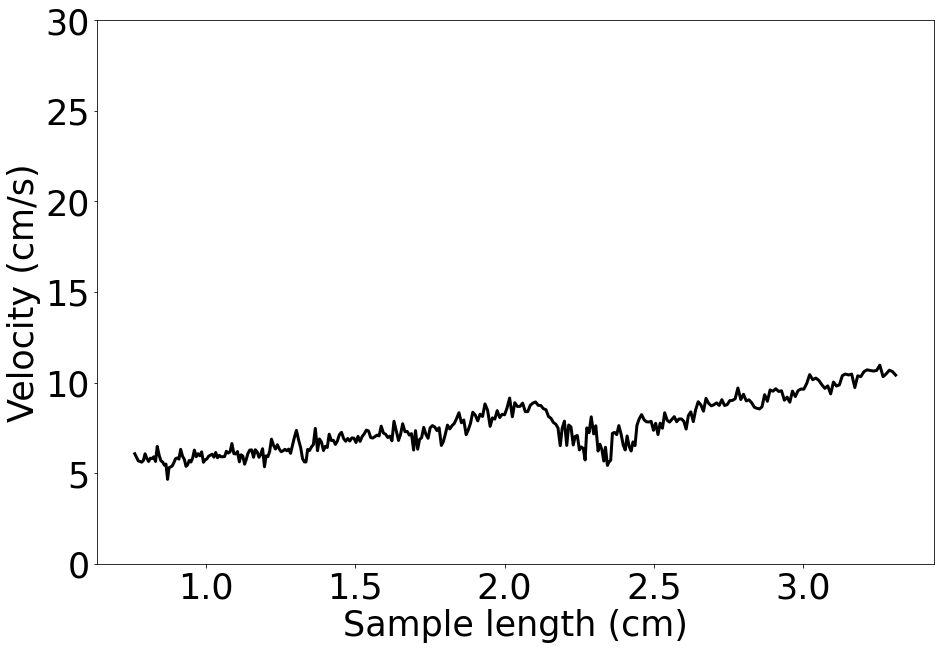

In [45]:
vel=[]
for i in range(len(x_center_list)-1):
    vel=vel+[x_center_list[i+1]-x_center_list[i]]
    
plt.plot(df["x_center"][:-1],np.array(vel)*1000,'-',linewidth=3,color="black", label="Original plot")
plt.rcParams["figure.figsize"] = (15,10)

font_size=35
plt.xlabel('Sample length (cm)',fontdict={'size':font_size})
plt.ylabel('Velocity (cm/s)',fontdict={'size':font_size})

plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=35) 

plt.ylim([0, 30])